In [18]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import wasserstein_distance

np.random.seed(2023)

In [19]:
class Perturbation(ABC):
    def __init__(self, pos_label=None, n_points=20):
        self.σs = np.linspace(0, 1, num=n_points, endpoint=True)
        self.pos_label = 1 if pos_label is None else pos_label

    def get_auc(self, y, ŷ):
        fpr, tpr, _ = roc_curve(y, ŷ, pos_label=self.pos_label)
        return auc(fpr, tpr)

    def get_auc_gain(self, original_auc, y, ŷ):
        auc = self.get_auc(y, ŷ)
        return auc / original_auc

    def _check_inputs(self, ŷ):
        if ŷ.min() < 0 or 1 < ŷ.max():
            raise Exception('Supports scores between 0 and 1 and the moment')

    @abstractmethod
    def _get_y_scoreδ(self, y_true, y_score, σ):
        raise NotImplementedError

    def _get_gain(self, original_auc, y, ŷ, σ):
        ŷ = self._get_y_scoreδ(y, ŷ, σ)
        return self.get_auc_gain(original_auc, y, ŷ)

    def __call__(self, y, ŷ):
        self._check_inputs(ŷ)
        original_auc = self.get_auc(y, ŷ)

        auc_gains = [self._get_gain(original_auc, y, ŷ, σ) for σ in self.σs]
        auc_gains = np.array(auc_gains)

        perturbation_auc = np.trapz(auc_gains) / len(auc_gains)
        return self.σs, auc_gains, perturbation_auc

In [20]:
class Robustness(Perturbation):
    def _get_y_scoreδ(self, y_true, y_score, σ):
        return np.random.normal(loc=y_score, scale=σ)

class Bias(Perturbation):
    def _get_y_scoreδ(self, y, ŷ, σ):
        is_pos = y == self.pos_label
        ŷ = np.copy(ŷ)
        ŷ[is_pos] -= σ
        return ŷ

In [21]:
class Plot:
    def __init__(self, bins=30):
        self.fig, self.axs = plt.subplots(1, 3)
        self.bins = bins

    def _split_predictions(self, labels, predictions):
        is_pos = labels == 1
        ŷ_pos = predictions[is_pos]
        ŷ_neg = predictions[~is_pos]
        return ŷ_pos, ŷ_neg

    def plot_hist(self, y, ŷ):
        ŷ_pos, ŷ_neg = self._split_predictions(y, ŷ)
        fpr, tpr, _ = roc_curve(y, ŷ)

        self.axs[0].hist(ŷ_neg, label='Negative Class', alpha=0.7, bins=self.bins)
        self.axs[0].hist(ŷ_pos, label='Positive Class', alpha=0.7, bins=self.bins)
        self.axs[0].set_title(f"ROC AUC = {auc(fpr, tpr):.5f}")
        self.axs[0].set_xlim([0, 1])
        self.axs[0].legend()
        self.axs[0].set_xlabel('Predictions')
        self.axs[0].set_ylabel('Frequency')

    def plot_curve(self, σs, auc_gains, pertubation_auc, axs_index, type):
        self.axs[axs_index].set_ylim([0,1])
        self.axs[axs_index].set_xlim([0, 1])
        self.axs[axs_index].plot(σs, auc_gains)
        self.axs[axs_index].set_title(f'{type} perturbation AUC = {pertubation_auc:.3f}')
        self.axs[axs_index].set_xlabel('Perturbation scale')
        self.axs[axs_index].set_ylabel('Perturbed-predictions AUC decay')

    def __call__(self, y, ŷ):
        self.plot_hist(y, ŷ)

        σs, auc_gains, perturbation_auc = Robustness()(y, ŷ)
        self.plot_curve(σs, auc_gains, perturbation_auc, 1, 'Robustness')

        σs, auc_gains, perturbation_auc = Bias()(y, ŷ)
        self.plot_curve(σs, auc_gains, perturbation_auc, 2, 'Bias')

        plt.tight_layout()
        self.fig.set_size_inches(20, 4)
        plt.show()

In [22]:
class OTMatrix:
    def __init__(self, n_bins=50):
        self.n_bins = n_bins

    def _subsample(self, samples, n):
        return np.random.choice(samples, n, replace=False)

    def _adjust_sample_sizes(self, source_samples, target_samples):
        if len(source_samples) < len(target_samples):
            target_samples = self._subsample(target_samples, len(source_samples))
        elif len(target_samples) < len(source_samples):
            source_samples = self._subsample(source_samples, len(target_samples))
        return source_samples, target_samples

    def _get_hists(self, source_samples, target_samples):
        source_samples, target_samples = self._adjust_sample_sizes(source_samples, target_samples)
        source_hist, source_bin_edges = np.histogram(source_samples, bins=self.n_bins)
        target_hist, target_bin_edges = np.histogram(target_samples, bins=self.n_bins)
        return source_hist, target_hist

    def __call__(self, y_valid, ŷ_valid, y_test, ŷ_test, verbose=False):
        ŷ_valid_0 = ŷ_valid[y_valid==0]
        ŷ_valid_1 = ŷ_valid[y_valid==1]
        ŷ_test_0 = ŷ_test[y_test==0]
        ŷ_test_1 = ŷ_test[y_test==1]

        v0t0 = wasserstein_distance(ŷ_valid_0, ŷ_test_0)
        v1t1 = wasserstein_distance(ŷ_valid_1, ŷ_test_1)
        v0v1 = wasserstein_distance(ŷ_valid_0, ŷ_valid_1)
        t0t1 = wasserstein_distance(ŷ_test_0, ŷ_test_1)
    
        costs = dict()
        costs['V1'] = {'V0': v0v1, 'T1': v1t1}
        costs['T0'] = {'V0': v0t0, 'T1': t0t1}
        df = pd.DataFrame.from_dict(costs)
        return df

In [23]:
def get_0_1_constrained_normal_distribution(μ, σ, N):
    ŷ = np.random.normal(μ, σ, N)
    is_between_0_and_1 = np.bitwise_and(ŷ<1, ŷ>0)
    return ŷ[is_between_0_and_1]


def simulate_model_results(N, μ_neg, μ_pos, σ):
    ŷ_neg = get_0_1_constrained_normal_distribution(μ_neg, σ, N)
    ŷ_pos = get_0_1_constrained_normal_distribution(μ_pos, σ, N)
    ŷ = np.concatenate((ŷ_neg, ŷ_pos))
    y = np.concatenate((np.zeros(len(ŷ_neg)), np.ones(len(ŷ_pos))))
    return y, ŷ

Validation set


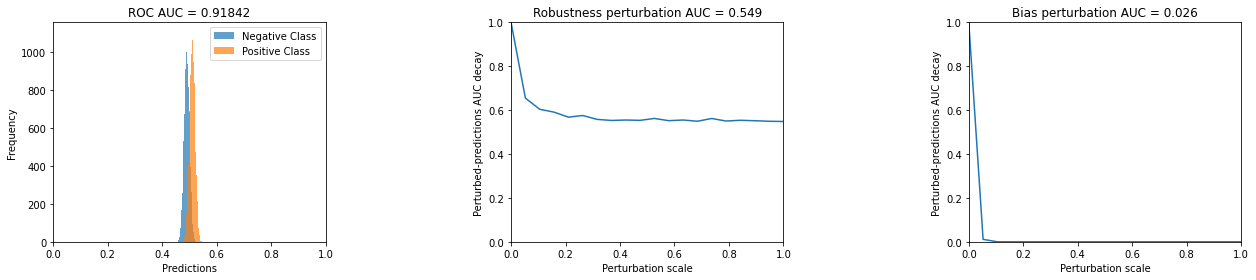

Test set


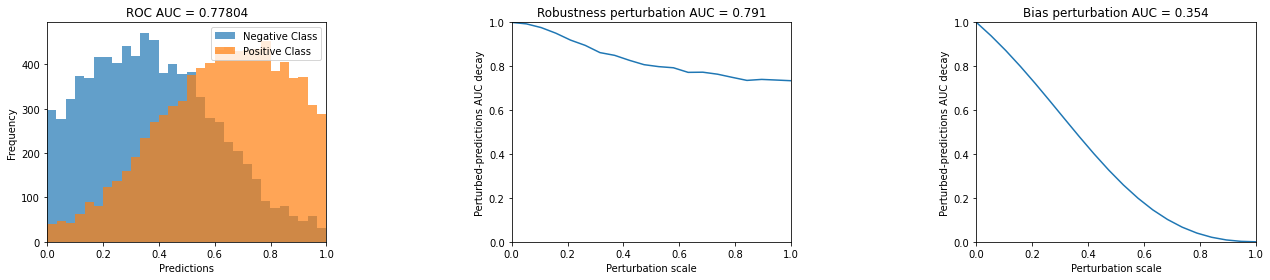

,V1,T0
V0,0.019769,0.202093
T1,0.207024,0.245577


In [24]:
N = 10000
σ = 0.3

y_valid, ŷ_valid = simulate_model_results(N, μ_neg=0.49, μ_pos=0.51, σ=0.01)
y_test, ŷ_test   = simulate_model_results(N, μ_neg=0.30, μ_pos=0.70, σ=0.30)

# y_valid, ŷ_valid = simulate_model_results(N, μ_neg=0.05, μ_pos=0.95, σ=0.01)
# y_test, ŷ_test   = simulate_model_results(N, μ_neg=0.05, μ_pos=0.95, σ=0.30)

print("Validation set")
Plot()(y_valid, ŷ_valid)
print("Test set")
Plot()(y_test, ŷ_test)

costs = OTMatrix()(y_valid, ŷ_valid, y_test, ŷ_test)
costs

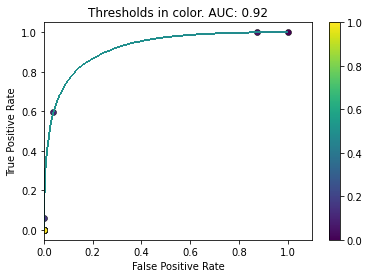

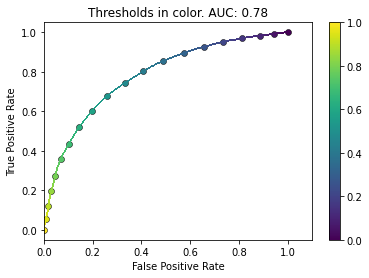

In [25]:
class PlotROC:

    def __init__(self, colormap='viridis', linewidth=2, n_dots=20):
        self.colormap = colormap
        self.linewidth = linewidth
        self.n_dots = n_dots

    def _display_dots_for_selected_thresholds(self, fpr, tpr, thresholds, n_dots):
        cmap = plt.get_cmap(self.colormap)  # Get the actual colormap object
        norm = Normalize(vmin=thresholds.min(), vmax=thresholds.max())
        
        for thresh in np.linspace(thresholds.min(), thresholds.max(), n_dots):
            closest_idx = np.argmin(np.abs(thresholds - thresh))
            x, y = fpr[closest_idx], tpr[closest_idx]

            color = cmap(norm(thresh))
            plt.scatter(x, y, color=color, edgecolors='black', linewidths=0.5)

    def _get_corrected_fpr_tpr_thresholds(self, y, ŷ):
        fpr, tpr, thresholds = roc_curve(y, ŷ)
        assert thresholds[0] >= 1, "First threshold value is expected to be >= 1.0."
        thresholds[0] = 1
        return fpr, tpr, thresholds

    def _get_segments(self, fpr, tpr, thresholds):
        points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        return segments

    def _get_lc(self, segments, thresholds):
        lc = LineCollection(segments, cmap=self.colormap, norm=plt.Normalize(0, 1))
        lc.set_array(thresholds)
        lc.set_linewidth(self.linewidth)
        return lc

    def __call__(self, y, ŷ):
        fpr, tpr, thresholds = self._get_corrected_fpr_tpr_thresholds(y, ŷ)

        segments = self._get_segments(fpr, tpr, thresholds)
        lc = self._get_lc(segments, thresholds)

        plt.title(f"Thresholds in color. AUC: {roc_auc_score(y, ŷ):.2f}")
        plt.gca().add_collection(lc)
        plt.colorbar(lc)    
        self._display_dots_for_selected_thresholds(fpr, tpr, thresholds, self.n_dots)

        plt.xlim(0, 1.1)  # a bit wider to make space for labels
        plt.ylim(-0.05, 1.05)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

plotter = PlotROC()(y_valid, ŷ_valid)
plt.show()

PlotROC()(y_test, ŷ_test)
plt.show()